# Проект: классификация

In [209]:
# Импорт необходимых библиотек.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from itertools import compress
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeCV
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [210]:
# Импорт датасета с данными.
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


В данном проекте предстоит решить задачу классификации, которая часто встаёт перед аналитиками, работающими в банковском секторе. Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними. Банком были предоставлены данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Нужно проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. Тем самым можно будет поднять доходы банка и понять целевую аудиторию, которую необходимо привлекать путём рекламы и различных предложений.

Банк предоставил данные, чтобы можно было выявить решающие факторы для успеха маркетинговой кампании. В целом их можно разделить на несколько групп.

Данные о клиентах банка:
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

Целевая переменная - deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её нужно будет предсказать в данном кейсе.

In [211]:
# Исследуем данные на предмет пропусков.
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Пропуски обнаружены только в признаке balance в количестве 25 штук. Скорее всего, эти люди просто открывают счета в банках без депозита, и их пропуск означает, что сотрудники банка пропускают данный пункт.

### Задание 2

In [212]:
# Исследуем признак job на предмет скрытых пропусков. Для этого поссмотрим на названия и количество значений в этом признаке.
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Было выялено значение "unknown", которое означает "неизвестно" в количестве 70 значений.

### Задание 3

In [213]:
# Преобразуем признак balance в вещественное число float, так как баланс представлен в строковом виде и он не поддается статистике.
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

# Применим функцию make_convert и изменим тип признака на численное.
df['balance'] = df['balance'].apply(make_convert)

# Среднее значение баланса, преобразованного в корректный вид.
print('Среднее значение баланса: {:.3f}'.format(df['balance'].mean()))

Среднее значение баланса: 1529.129


### Задание 4

In [214]:
# Заполнение пропущенных значений balance на медианное значение.
df['balance'] = df['balance'].fillna(df['balance'].median())

# Среднее значение баланса после заполнения пропусков.
print('Среднее значение баланса после заполнения пропусков в данных: {:.3f}'.format(df['balance'].mean()))

Среднее значение баланса после заполнения пропусков в данных: 1526.936


### Задание 5

In [215]:
# Обработка пропусков в категориальных признаках job и education, замена их на модальные значения.
# Выявим и посчитаем категории по уровню образования.
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [216]:
# Обработка пропусков в категориальных признаках job и education и замена их на модальные значения.

# Замена скрытых пропусков 'unknown' в признаке 'job'.
m_job = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)

# Замена скрытых пропусков 'unknown' в признаке 'education'.
m_education = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: m_education if x == 'unknown' else x)


# Рассчитиаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования.

# Фильтрация по популярному уровню образования и популярной работе.
df_balance = df[(df.job == 'management') & (df.education == 'secondary')]

# Средний баланс выбранных клиентов.
print('Средний баланс выбранных клиентов: {}'.format(round(df_balance['balance'].mean(), 3)))

Средний баланс выбранных клиентов: 1598.883


### Задание 6

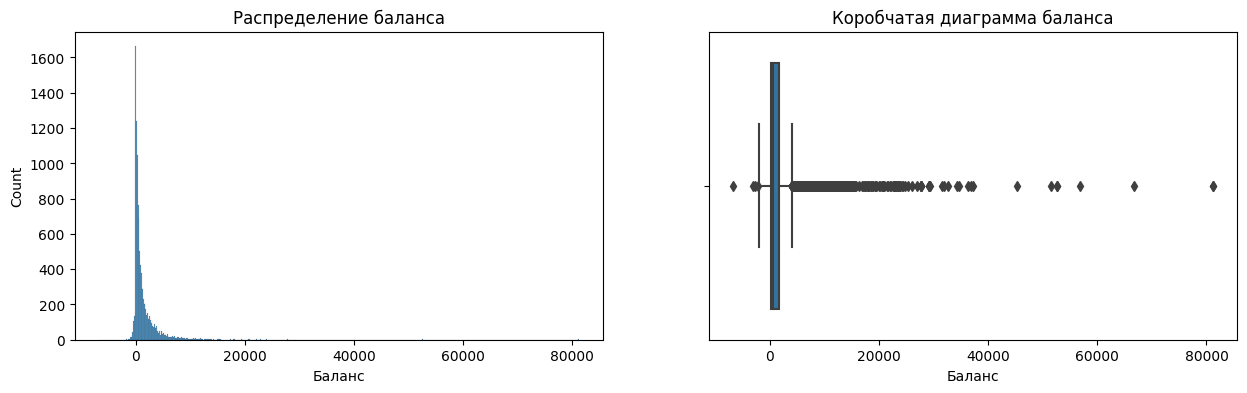

In [217]:
# Визуализация в виде гистограммы и коробчатой диаграммы признака 'balance' для выявления выбросов.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# Гистограмма баланса.
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Распределение баланса');
histplot.set_xlabel('Баланс');

# Коробчатая диаграмма баланса.
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Коробчатая диаграмма баланса');
boxplot.set_xlabel('Баланс');

После визуализации видно, что баланс клиентов имеет выбросы. Поэтому применим метод межквартильного размаха для удаления этих выбросов.

In [218]:
# Применим метод межквартильного размаха для удаления выбросов.
# Метод Тьюки для работы с выбросами.
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, upper_bound, lower_bound # Возврат выбросов, оставшихся записей, верхней и нижней границ выбросов.

# Применим метод Тьюки для выявления и очистки выбросов, а так же выявления их границ.
outliers, cleaned, upper_bound, lower_bound = outliers_iqr(df, 'balance')

# Число записей после мотода Тьюки.
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
# Границы значений выбросов.
print(f'Верхняя граница поиска выбросов по методу Тьюки: {upper_bound}')
print(f'Нижняя граница поиска выбросов по методу Тьюки: {lower_bound}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Верхняя граница поиска выбросов по методу Тьюки: 4063.0
Нижняя граница поиска выбросов по методу Тьюки: -2241.0


## Часть 2:  Разведывательный анализ

### Задание 1

Число клиентов открывших депозит:  4681
Число клиентов без депозита:  5424


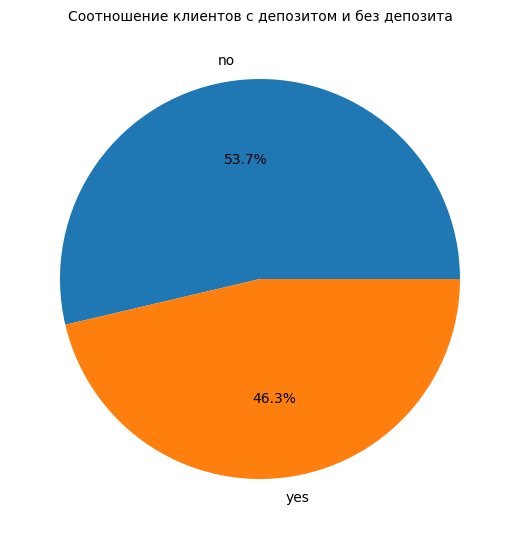

In [219]:
# Исследуем соотношение классов целевой переменной на предмет несбалансированности.

# Круговая диаграмма соотношения клиентов с депозитом и без.
ratio_clients = cleaned['deposit'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_title('Соотношение клиентов с депозитом и без депозита', fontsize=10),
axes.pie(
    ratio_clients,
    labels=ratio_clients.index,
    autopct='%.1f%%',
);
# Смотря на полученную диаграмму, можно видеть, что соотношение клиентов примерно равны между собой.
count_yes = cleaned[cleaned['deposit'] == 'yes'].shape[0]
count_no = cleaned[cleaned['deposit'] == 'no'].shape[0]
print('Число клиентов открывших депозит: ', count_yes)
print('Число клиентов без депозита: ', count_no)

### Задания 2 и 3

In [220]:
# Описательные статистики для количественных переменных.
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Средний возраст клиентов составляет 40 лет, что не противоречит дальнейшим исследованиям, где наибольшее число клиентов имеют возраст от 20 до 60 лет. Средний баланс клиентов равен 807 долларам. Продолжительность контактов длилось от 2 до 3881 секунд, а среднее значение равно 368, что может говорить о некоторой заинтересованности клиентов на предложение открыть депозит. Количество дней после предыдущего контакта и дату последнего контакта нужно рассматривать далее совместно с названием месяца, который является категориальным признаком.

Text(0, 0.5, 'Баланс')

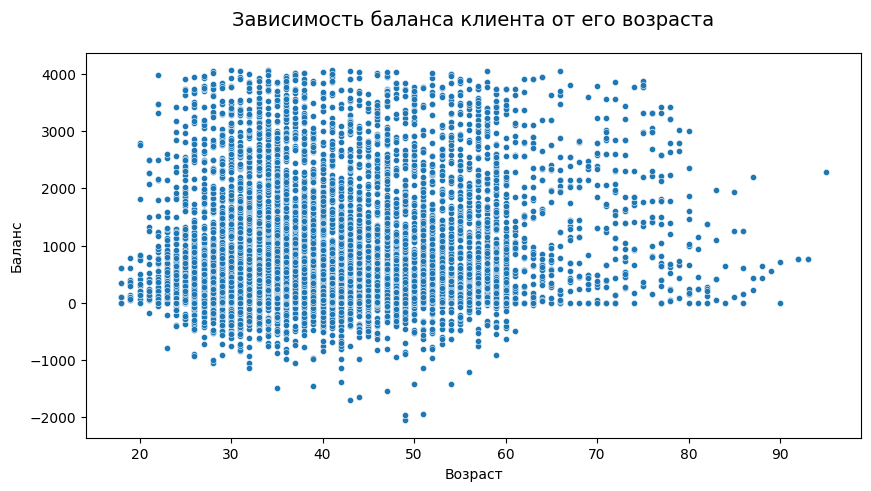

In [221]:
# Поссмотрим на зависимость баланса клиента от его возраста. Для этого построим диаграмму рассеяния.
fig = plt.figure(figsize=(10, 5))
relationship = sns.scatterplot(
    data=cleaned,
    x='age',
    y='balance',
    s=20,
)
relationship.set_title('Зависимость баланса клиента от его возраста', fontsize=14, y=1.05)
relationship.set_xlabel('Возраст')
relationship.set_ylabel('Баланс')

Зависимости баланса от возраста не выявлено. Интересно наблюдать потолок баланса в 4000 долларов, а так же его отрицательные значения. 
Еще можно увидеть, что основное количество клиентов имеют возраст от 20 до 60 лет с балансом от 0 до 4000 долларов.

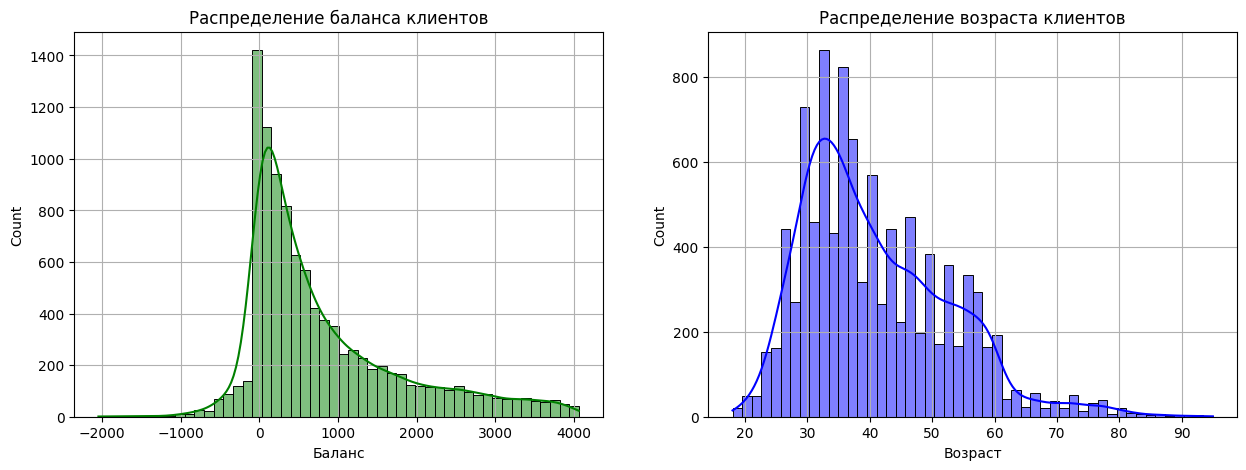

In [222]:
# Поссмотрим на распределение возраста и баланса клиентов в виде гистограмм.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Распределение баланса.
histplot_balance = sns.histplot(
    ax=axes[0],
    data=cleaned,
    x='balance',
    bins=50,
    kde=True,
    color='green',
)
histplot_balance.set_title('Распределение баланса клиентов', fontsize=12);
histplot_balance.set_xlabel('Баланс');
histplot_balance.grid()

# Распределение возраста.
histplot_age = sns.histplot(
    ax=axes[1],
    data=cleaned,
    x='age',
    bins=50,
    kde=True,
    color='blue',
)
histplot_age.set_title('Распределение возраста клиентов', fontsize=12);
histplot_age.set_xlabel('Возраст');
histplot_age.grid()

Распределение баланса логнормальное - количество депозитов уменьшается с увеличением баланса. Это легко объяснимо - немногие могут открыть депозит с высоким балансом. Распределение возраста напоминает нормальное распределение с правосторонней ассиметрией. Наибольшее количество клиентов имеют возраст в диапазоне от 20 до 60 лет. Резкий обвал начинается после 60 лет. Видимо, это связано с выходом на пенсию. Вероятно, в этом возрасте люди начинают тратить накопленные деньги, ввиду отсутствия заработной платы.

### Задания 4 и 5

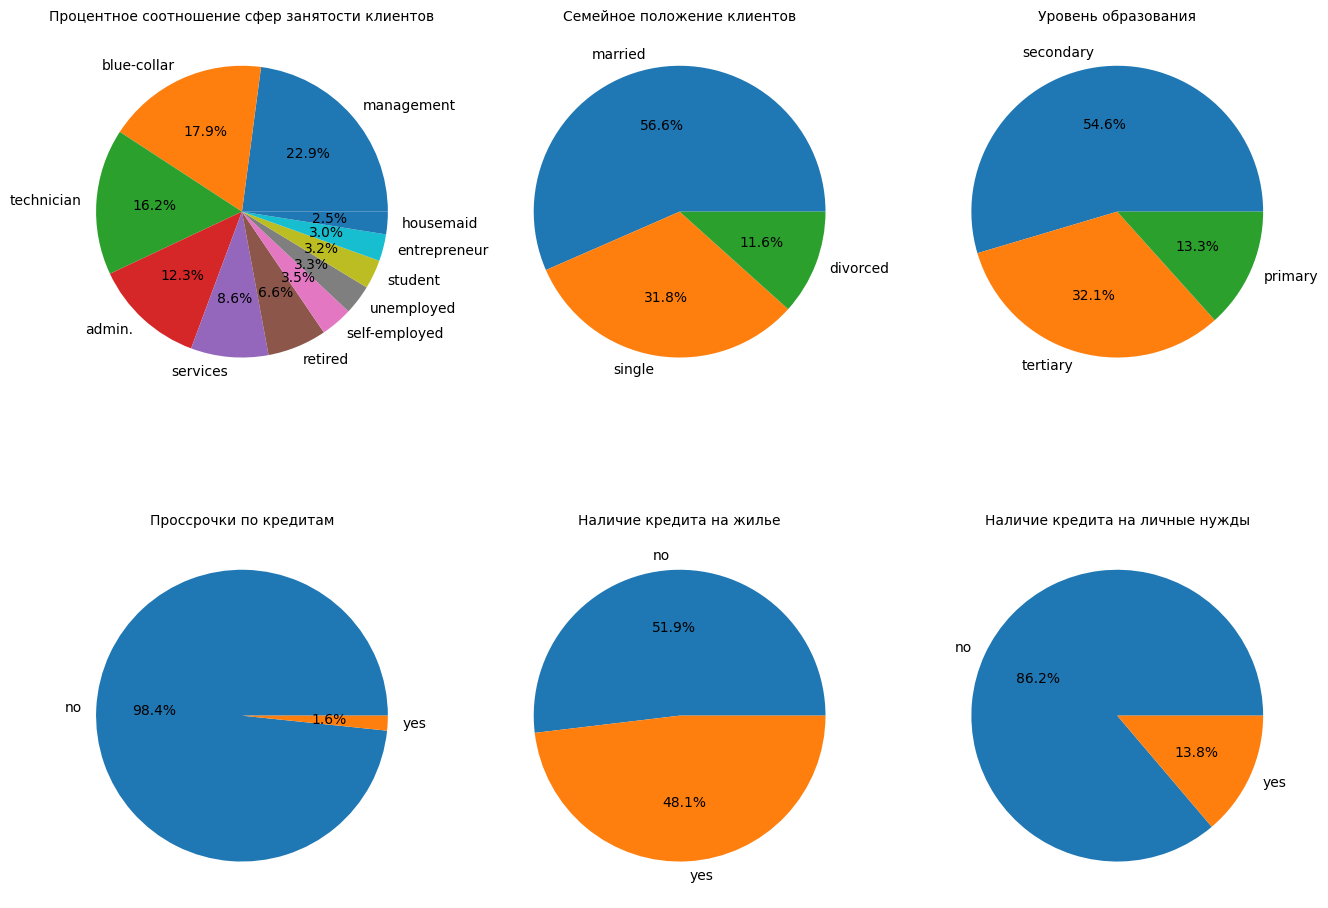

In [223]:
# Посмотрим на описательные статистики для категориальных переменных и проинтерпретируем результат.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))

# Процентное соотношение сфер занятости/
clients_job = cleaned['job'].value_counts()
axes[0,0].set_title('Процентное соотношение сфер занятости клиентов', fontsize=10),
axes[0,0].pie(
    clients_job,
    labels=clients_job.index,
    autopct='%.1f%%',
);
# Семейное положение клиентов.
clients_marital = cleaned['marital'].value_counts()
axes[0,1].set_title('Семейное положение клиентов', fontsize=10),
axes[0,1].pie(
    clients_marital,
    labels=clients_marital.index,
    autopct='%.1f%%',
);
# Уровень образования.
clients_education = cleaned['education'].value_counts()
axes[0,2].set_title('Уровень образования', fontsize=10),
axes[0,2].pie(
    clients_education,
    labels=clients_education.index,
    autopct='%.1f%%',
);
# Проссроченный кредит.
clients_default = cleaned['default'].value_counts()
axes[1,0].set_title('Проссрочки по кредитам', fontsize=10),
axes[1,0].pie(
    clients_default,
    labels=clients_default.index,
    autopct='%.1f%%',
);
# Наличие кредита на жилье.
clients_housing = cleaned['housing'].value_counts()
axes[1,1].set_title('Наличие кредита на жилье', fontsize=10),
axes[1,1].pie(
    clients_housing,
    labels=clients_housing.index,
    autopct='%.1f%%',
);
# Наличие кредита на личные нужды.
clients_loan = cleaned['loan'].value_counts()
axes[1,2].set_title('Наличие кредита на личные нужды', fontsize=10),
axes[1,2].pie(
    clients_loan,
    labels=clients_loan.index,
    autopct='%.1f%%',
);

В тройку лидеров по сфере занятости входят management, blue-collar (рабочие специальности) и технические специальности (technician). По семейному положению значительно преобладают клиенты состоящие в браке. Большинство клиентов имеют два образования - среднее и дополнительное. Проссрочек по кредитам почти нет, что является хорошим показателем для банка, чтобы предложить им открыть депозит, так как, вероятно, у них есть свободные деньги для этого. Большинство клиентов не имеют никаких кредитов, что так же говорит о возможности их согласия открыть депозит.

Text(112.72222222222221, 0.5, 'Количество кредитов на личные нужды')

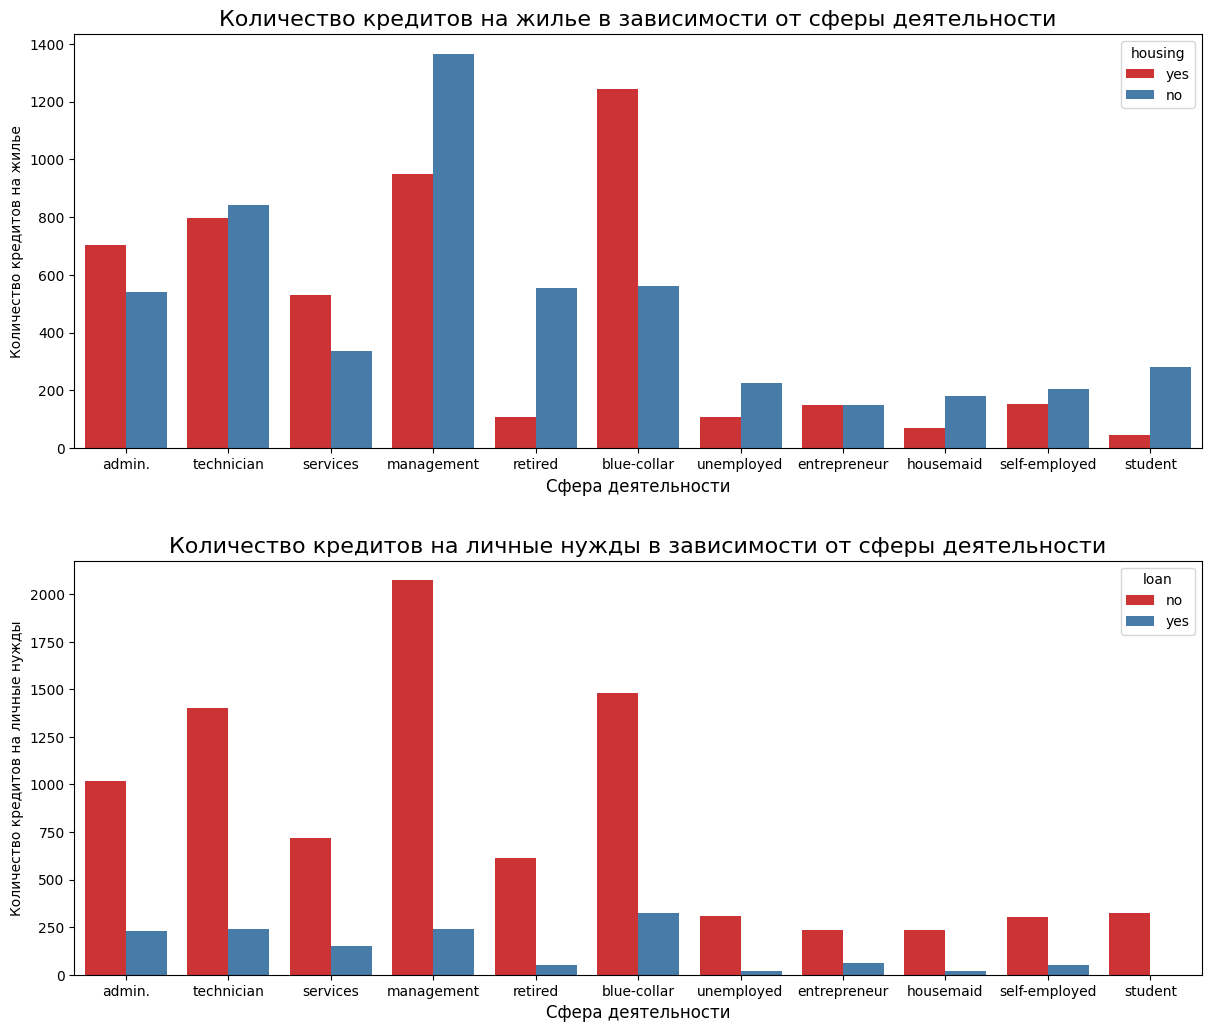

In [224]:
# Подсчитаем количество кредитов на личные нужды и жилье.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
fig.tight_layout(h_pad=6)

# График количества кредитов на жилье.
sns.countplot(
    ax=axes[0],
    data=cleaned, 
    x='job',
    hue='housing',
    palette='Set1',
)
axes[0].set_title('Количество кредитов на жилье в зависимости от сферы деятельности', fontsize=16)
axes[0].set_xlabel('Сфера деятельности', fontsize=12)
axes[0].set_ylabel('Количество кредитов на жилье')

# График количества кредитов на личные нужды.
sns.countplot(
    ax=axes[1],
    data=cleaned, 
    x='job', 
    hue='loan',
    palette='Set1',
)
axes[1].set_title('Количество кредитов на личные нужды в зависимости от сферы деятельности', fontsize=16)
axes[1].set_xlabel('Сфера деятельности', fontsize=12)
axes[1].set_ylabel('Количество кредитов на личные нужды')

По приведенным графикам можно заметить, что менеджеры и синие воротнички чаще берут кредиты на жилье по сравнению с остальными специальностями. Но в тоже время они очень редко берут кредит на личные нужды. Последний график так же подтверждает график из предыдущего исследования малому количеству кредитов на личные нужды. У администраторов и технических рабочих примерно половина имеет кредит на жилье очень мало на личные нужды. Остальные сферы деятельности вносят небольшой вклад в общую статистику, ввиду их небольшого количества.

Text(0.5, 1.0, 'Процентное соотношение количества маркетинговых компаний по месяцам')

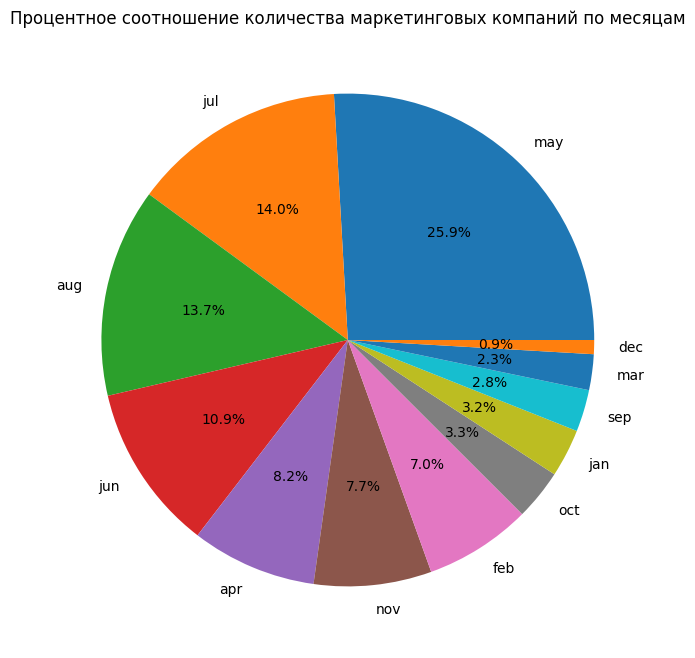

In [225]:
# График соотношения количества маркетинговых компаний по месяцам.
fig = plt.subplots(figsize=(8,8))
month_count = cleaned['month'].value_counts()
plt.pie(
    month_count,
    labels=month_count.index,
    autopct='%.1f%%',
);
plt.title('Процентное соотношение количества маркетинговых компаний по месяцам', fontsize=12)

По графику видно, что маркетинговая компания активно велась в мае, июне, июле и августу.

### Задание 6

In [226]:
# Узнаем, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

# Наличие депозита в зависимости от прошлой маркетинговой компании.
status = pd.DataFrame(cleaned.groupby('poutcome')['deposit'].value_counts())
status

deposit
poutcome deposit         
failure  no           562
         yes          547
other    yes          265
         no           216
success  yes          861
         no            84
unknown  no          4562
         yes         3008

Видно, что количество успехов в текущей маркетинговой компании намного превалирует над количеством неудач у клиентов, которые согласились открыть депозит в прошлый раз.

### Задание 7

Text(0, 0.5, 'Процент неудач')

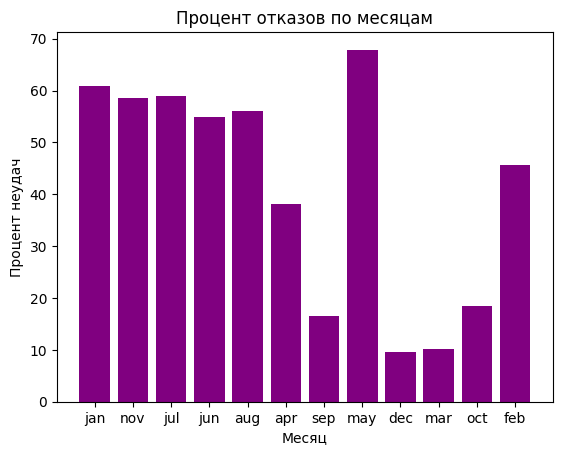

In [227]:
# Выявим месяц в котором чаще всего отказывались от предложения открыть депозит.

# Создаем список месяцев для цикла.
months_list = list(set(cleaned['month']))
# Список процентов неудач.
ratio_deposit = []

# Подсчет количества отказов для каждого месяца.
for month in months_list:
    ratio = cleaned[(cleaned['month']==month)&(cleaned['deposit']=='no')].shape[0] / (cleaned[cleaned['month']==month].shape[0])
    ratio_deposit.append(ratio*100)

# Создаем датасет из ранее полученных данных.
months_ratio = pd.Series(
    data = ratio_deposit,
    index = months_list
)
# Строим столбчатую диаграмму для выявления месяца с наибольшим количеством отказов.
plt.bar(
    months_list, 
    ratio_deposit,
    color='purple'
)
plt.title('Процент отказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Процент неудач')

Меньше всего неудач по открытию депозита приходятся на март, сентябрь, октябрь и декабрь. В этих месяцах доля клиентов, открывших депозит, была больше, чем в остальных. Исходя из предыдущего исследования маркетинговой компании, можно сделать вывод, что больше отказов было в месяцы наибольшей активности маркетинговой компании. Это выглядит логично, так как банк наиболее активно продвигал компанию в моменты нежелания клиентов открывать депозит.

### Задание 8

Text(0, 0.5, 'Процент клиентов открывших депозит')

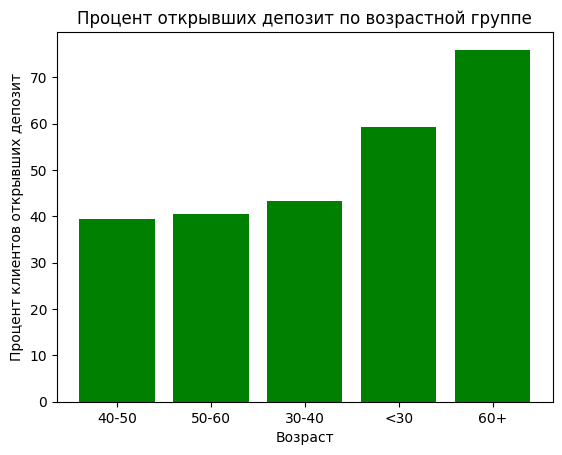

In [228]:
# Создание возрастных групп. Определение, в каких группах более склонны открывать депозит, чем отказываться от предложения.

# Создание признака с категориями по возрасту.
def age_range(x):
    if x < 30:
        return '<30'
    elif x >= 30 and x < 40:
        return '30-40'
    elif x >= 40 and x < 50:
        return '40-50'
    elif x >= 50 and x < 60:
        return '50-60'
    else:
        return '60+'

# Создаем признак с категориями по возрасту.
cleaned['age_range'] = cleaned['age'].apply(age_range)

# Создаем список категорий возрастов.
age_ranges = list(set(cleaned['age_range']))
# Список количества клиентов открывших депозит.
deposit_yes = []
# Находим процент клиентов открывших депозит в разрезе возрастных групп.
for range in age_ranges:
    ratio_yes = cleaned[(cleaned['age_range']==range)&(cleaned['deposit']=='yes')].shape[0] / cleaned[cleaned['age_range']==range].shape[0]
    deposit_yes.append(ratio_yes*100)

# Создаем датасет.
deposit_ratio = pd.Series(
    data = age_range,
    index = deposit_yes
)
# Диаграмма зависимости количества открывших депозит от возраста.
plt.bar(
    age_ranges, 
    deposit_yes,
    color='green'
)
plt.title('Процент открывших депозит по возрастной группе')
plt.xlabel('Возраст')
plt.ylabel('Процент клиентов открывших депозит')

По диаграмме видно, что к депозитам склонны клиенты в возрасте до 30 и после 60 лет. Можно предположить, что те, кто открывает депозит в возрасте до 30, стараются накопить капиталл, пока они находятся в продуктивном возрасте. А клиенты старше 60, скорее всего, соглашаются на депозит, потому что имеют свободные средства, накопленные ранее.

### Задания 9 и 10

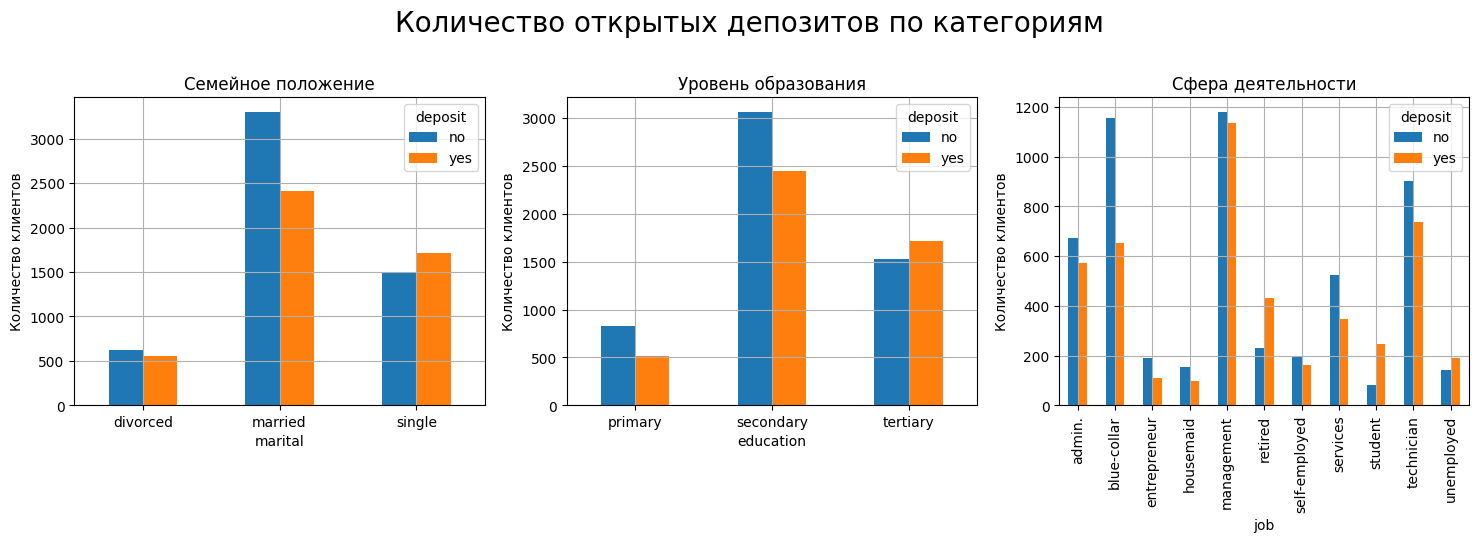

In [229]:
# Построим визуализации, отражающие количество тех, кто открыл депозит, и тех, кто его не открыл, для категорий представленных ниже:
# Посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:
# 1. семейное положение;
# 2. уровень образования;
# 3. сфера занятости.

# Сводная таблица по семейному положению.
pivot_marital = cleaned.pivot_table(
    values='job', # для подсчета факта присутствия строки в данных для функции aggfunc='count'.
    index='marital',
    columns='deposit',
    aggfunc='count')

# Сводная таблица по уровню образования.
pivot_education = cleaned.pivot_table(
    values='job', # для подсчета факта присутствия строки в данных для функции aggfunc='count'.
    index='education',
    columns='deposit',
    aggfunc='count')

# Сводная таблица по сфере деятельности.
pivot_job = cleaned.pivot_table(
    values='marital', # для подсчета факта присутствия строки в данных для функции aggfunc='count'.
    index='job',
    columns='deposit',
    aggfunc='count')

# Строим графики по категориям.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
fig.suptitle('Количество открытых депозитов по категориям', fontsize=20, x=0.5, y=1.1)

# Столбчатая диаграмма по семейному положению.
pivot_marital.plot(
    kind='bar',
    ax=axes[0])
axes[0].set_title('Семейное положение')
axes[0].set_ylabel('Количество клиентов')
axes[0].tick_params(axis='x', labelrotation = 0)
axes[0].grid()

# Столбчатая диаграмма по уровню образования.
pivot_education.plot(
    kind='bar',
    ax=axes[1])
axes[1].set_title('Уровень образования')
axes[1].set_ylabel('Количество клиентов')
axes[1].tick_params(axis='x', labelrotation = 0)
axes[1].grid()

# Столбчатая диаграмма по семейному положению.
pivot_job.plot(
    kind='bar',
    ax=axes[2])
axes[2].set_title('Сфера деятельности')
axes[2].set_ylabel('Количество клиентов')
axes[2].tick_params(axis='x', labelrotation = 90)
axes[2].grid()

По диаграмам видно, что по количеству открытых и неоткрытых депозитов, лидируют клиенты состоящие в браке и специалисты. Это можно объяснить их количественным преобладанием над остальными категориями, как было выявлено в предыдущих исследованиях. Большое количество депозитов приходится на менеджеров, администраторов, рабочих и технических специалистов.

### Задание 11

Text(0.5, 1.05, 'Количество неоткрытых депозитов')

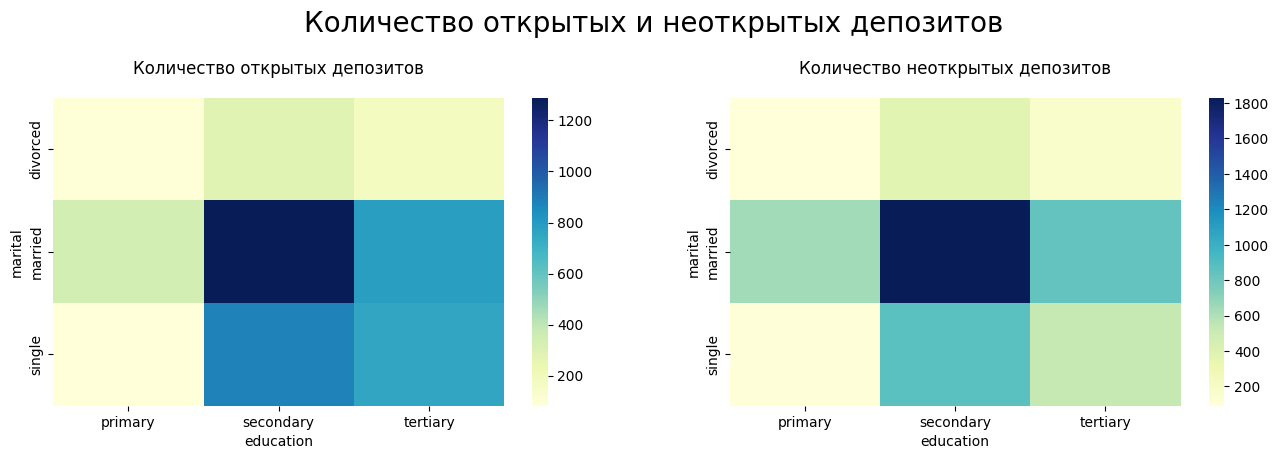

In [230]:
# Посмотрим на количество депозитов на пересечении семейного положения и образования. 

# Строим сводную таблицу семейного положения с уровнем образования для открывших депозит.
cleaned_yes = cleaned[cleaned['deposit']=='yes']
heatmap_yes_hm = cleaned_yes.pivot_table(
    values='deposit',
    index='marital',
    columns='education',
    aggfunc='count')

# Строим сводную таблицу семейного положения с уровнем образования для неоткрывших депозит.
cleaned_no = cleaned[cleaned['deposit']=='no']
heatmap_no_hm = cleaned_no.pivot_table(
    values='deposit',
    index='marital',
    columns='education',
    aggfunc='count')

# Задаем сетку графиков.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
fig.suptitle('Количество открытых и неоткрытых депозитов', fontsize=20, x=0.5, y=1.1)

# Тепловая карта для открывших депозит.
heatmap1 = sns.heatmap(data=heatmap_yes_hm, cmap='YlGnBu', ax=axes[0])
axes[0].set_title('Количество открытых депозитов', y=1.05)

# Тепловая карта для неоткрывших депозит.
heatmap2 = sns.heatmap(data=heatmap_no_hm, cmap='YlGnBu', ax=axes[1])
axes[1].set_title('Количество неоткрытых депозитов', y=1.05)

По построеным тепловым картам видно, что наибольшее число клиентов открывших депозит, являются людьми со специальным образованием состоящие и не состоящие в браке. Так же таких людей много и по неоткрытым депозитам.

## Часть 3: преобразование данных

In [231]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_range
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


### Задание 1

In [232]:
# Кодирование категориального порядкового признака education, который означает уровень образования.

# Инициализация кодировщика.
le_ed = LabelEncoder()

# Обучение кодировщика и преобразование признака.
cleaned['education'] = le_ed.fit_transform(cleaned['education'])

# Кодируем признак age_range.
cleaned['age_range'] = le_ed.fit_transform(cleaned['age_range'])

# Ответ на задание.
print('Сумма получившихся значений для признака education: {}'.format(cleaned['education'].sum()))

Сумма получившихся значений для признака education: 11995


### Задания 2 и 3

In [233]:
# Перекодируем переменные в бинарный признак, где 'yes' - это 1, а 'no' - это 0.

# Кодирование депозита.
cleaned['deposit'] = cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
# Кодирование проссроченного кредита.
cleaned['default'] = cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
# Кодирование кредита на жилье.
cleaned['housing'] = cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
# Кодирование кредита на личные нужды.
cleaned['loan'] = cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)

# Ответ на задание 2. Вычислить стандартное отклонение по преобразованной в корректный вид целевой переменной deposit
deposit_std = cleaned['deposit'].std()
print('Стандартное отклонение депозита: {}'.format(round(deposit_std, 3)))

# Ответ на задание 3. Вычислить среднее арифметическое для каждой из получившихся переменных, сложить три результата и в качестве ответа подсчитать итог.
sum_cl = round((cleaned['default'].mean() + cleaned['housing'].mean() + cleaned['loan'].mean()), 3)
print('Среднее арифметическое признаков default, housing и loan: {}'.format(sum_cl))

Стандартное отклонение депозита: 0.499
Среднее арифметическое признаков default, housing и loan: 0.635


### Задание 4

In [234]:
# Посчитаем, сколько теперь всего признаков в датасете. Посчитаем уже добавленные dummy-переменные, но до удаления номинальных.

# Список номинальных признаков.
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']

# Создание dummy-переменных.
clothing_dummies = pd.get_dummies(cleaned[categorial_features])

# Объединение таблиц.
cleaned_concat = pd.concat([cleaned, clothing_dummies], axis=1)

# Количесвто признаков.
print(f'Количество признаков: {cleaned_concat.shape[1]}')

Количество признаков: 51


### Задания 5 и 6

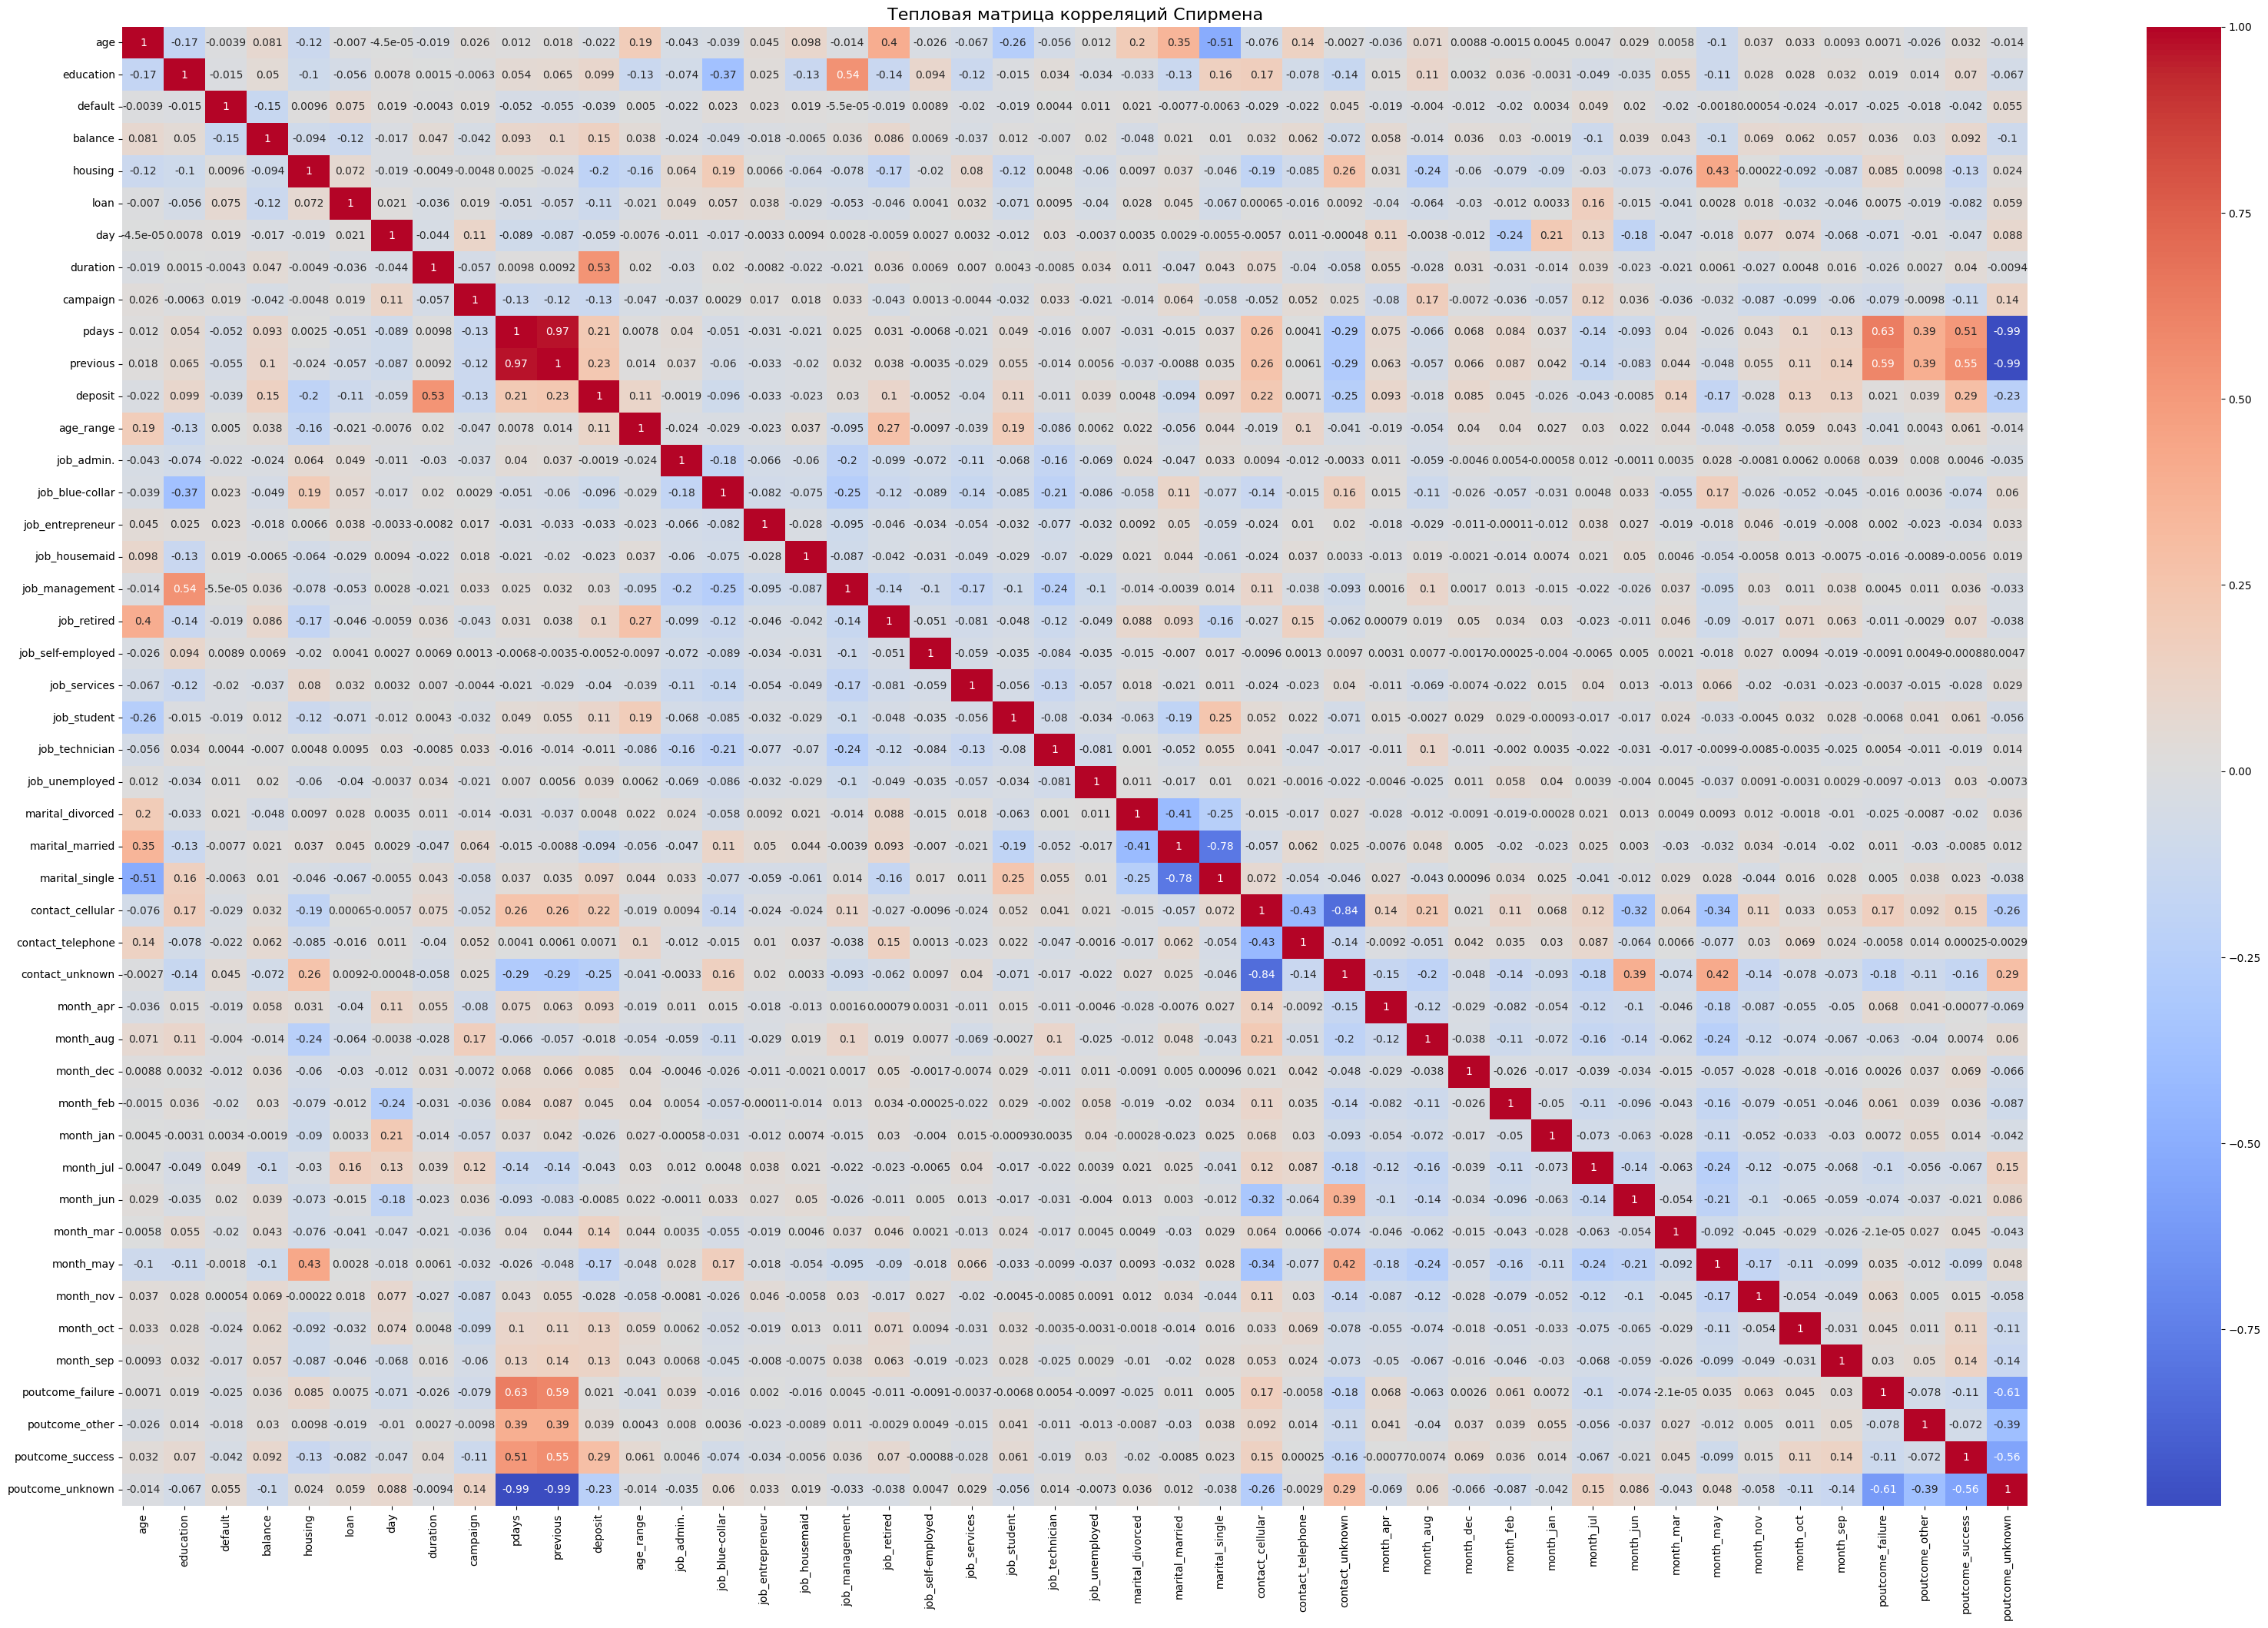

In [235]:
# Построение корреляционной матрицы и оценка данных на предмет наличия мультиколлинеарности.

# Матрица корреляций по Спирмену.
fig = plt.figure(figsize=(40, 25))
heatmap = sns.heatmap(cleaned_concat.corr(method = 'spearman'), annot = True, cmap='coolwarm')
heatmap.set_title('Тепловая матрица корреляций Спирмена', fontsize=16)
plt.show()

In [236]:
# 5 признаков, в наибольшей степени коррелирующие с целевой переменной, по убыванию силы линейной взаимосвязи.
corr = cleaned_concat.corr()
new_corr = corr['deposit'].reset_index()
sort_corr = new_corr.sort_values('deposit', ascending=False)
sort_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


### Задания 7 и 8

In [237]:
# Определить целевую переменную и предикторы.

# Определяем факторы и целевую переменную.
X = cleaned_concat.drop(['deposit'], axis=1)
y = cleaned_concat['deposit']

# Разделение выборки на обучающую и тестовую с добавлением аргумента stratify, определяющий сохранение соотношений целевого признака.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

# Размер тестовой выборки.
print(f'Размер тестовой выборки: {X_test.shape[0]}')

# Среднее значение целевой переменной deposit на тестовой выборке
deposit_mean = round(y_test.mean(), 2)
print(f'Среднее значение целевой переменной deposit на тестовой выборке: {deposit_mean}')

Размер тестовой выборки: 3335
Среднее значение целевой переменной deposit на тестовой выборке: 0.46


### Задание 9

In [238]:
# С помощью SelectKBest отберем 15 наиболее подходящих признаков

# Перед отбором оставляем только числовые признаки.
X_train = X_train.select_dtypes(include=['float64', 'int32', 'int64', 'uint8'])

# Выбираем 15 признаков.
skb = SelectKBest(f_classif, k=15).fit(X_train, y_train)
mask = skb.get_support()
name_col = X_train.columns.values

# Список наилучших признаков.
skb_list = list(compress(name_col, mask))

# Оставляем только 15 наилучших признаков и целевую переменную.
skb_list.append('deposit')
cleaned_15 = cleaned_concat[skb_list]

### Задание 10

In [239]:
# Рассчитаем среднее арифметическое баланса из тестовой выборки.

# Создаем список с названиями признаков для дальнейшего преобразования после нормализации.
col_names = list(cleaned_15.columns)

# Инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# Нормализуем исходный датасет без целевой переменной.
df_mm = mm_scaler.fit_transform(cleaned_15)

# Преобразуем после нормализации промежуточный датасет в полноценный датафрейм для дальнейшего машинного обучения.
df_bank = pd.DataFrame(df_mm, columns=col_names)
df_bank['deposit'] = df_bank['deposit'].astype(int)

# Определяем факторы и целевую переменную.
X = df_bank.drop(['deposit'], axis=1)
y = df_bank['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

# Ответ на Задание 4.10. Рассчитаем среднее арифметическое баланса из тестовой выборки.
mean_1 = round(X_test['balance'].mean(), 2)
print('Среднее арифметическое баланса из тестовой выборки: {}'.format(mean_1))

Среднее арифметическое баланса из тестовой выборки: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [240]:
# Обучите логистическую регрессию и рассчитайте метрики качества accuracy.

# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
# Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
# Делаем предсказание для тренировочной выборки
y_test_pred = log_reg.predict(X_test)

# Делаем предсказание для тестовой выборки и вычисляем метрику accuracy.
accuracy_test = round(metrics.accuracy_score(y_test, y_test_pred), 2)
print('accuracy для тестовой выборки: {}'.format(accuracy_test))

accuracy для тестовой выборки: 0.8


### Задания 2,3,4

In [241]:
# Обучите решающие деревья, настройте максимальную глубину

# Создаем объект класса дерево решений.
trees_data = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=6, # После задания 2 добавлена глубина деревьев (для з.4) для поиска наилучшей глубины методом ручного перебора и нахождения accuracy для з.3 (0.81)
)
# Обучаем дерево по алгоритму CART.
trees_data.fit(X_train, y_train)

# Выводим значения метрики для тренировочной и тестовой выборок.
y_train_pred = trees_data.predict(X_train)
print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = trees_data.predict(X_test)
print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 0.82
Test: 0.81


### Задание 5

In [242]:
# Подбор оптимальных параметров с помощью gridsearch.

# Список гиперпараметров 'min_samples_split' и 'max_depth' для оптимизации:
param_grid = {
    'min_samples_split':[2, 5, 7, 10],
    'max_depth':[3,5,7]
}
# Вызываем класс GridSearchCV и передаем модель логистической регрессии 'LogisticRegression' и сетку искомых гиперпараметров 'param_grid'.
grid_search_1 = GridSearchCV(
    tree.DecisionTreeClassifier(
        random_state=42,
        ),
    param_grid=param_grid,  
    n_jobs = -1
)
# Обучаем дерево по алгоритму.
grid_search_1.fit(X_train, y_train)

# Выводим значение метрики F1 для тестовой выборки и значения наилучших гиперпараметров.
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [243]:
# Обучите на ваших данных случайный лес.

# Создаем объект класса случайный лес.
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    criterion='gini',
    min_samples_leaf=5,
    random_state=42
)
# Обучаем модель.
rf.fit(X_train, y_train)

# Делаем предсказание модели для тестовой выборки.
y_test_pred = rf.predict(X_test)

# Выводим значения метрики accuracy и recall для построенной модели на тестовой выборке.
print('Метрика accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Метрика recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Метрика accuracy на тестовой выборке: 0.83
Метрика recall на тестовой выборке: 0.83


### Задания 2 и 3

In [244]:
# Используйте для классификации градиентный бустинг и сравните качество со случайным лесом.

# Создаем модель градиентного бустинга.
gb = GradientBoostingClassifier(
    learning_rate=0.05, # темп обучения
    n_estimators=300, # число деревьев
    max_depth=5, # максимальная глубина дерева
    min_samples_leaf = 5, # количество листьев
    random_state=42 # генератор случайных чисел
)
# Обучаем модель.
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки.
y_test_pred = gb.predict(X_test)

# Посмотрим на метрику классификации F1 для тестовой выборки.
print('f1_score на тестовом наборе после градиентного бустинга: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе после градиентного бустинга: 0.82


Ответ на Задание 3.
Модель случайного леса, если посмотреть на метрики в целом, даёт более качественный прогноз.

### Задание 4

In [245]:
# Объедините уже известные вам алгоритмы с помощью стекинга, объединив те алгоритмы, которые уже были использовали ранее: 
# решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

# Создаем список базовых моделей в виде кортежей вида (наименование модели, модель).
estimators = [
    ('lg', linear_model.LogisticRegression(
        solver='sag', # алгоритм оптимизации
        random_state=42, # генератор случайных чисел
        max_iter=1000)), # количество итераций на сходимость
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy', # энтропия
        random_state=42,
        max_depth=6)), # глубина дерева
    ('gb', GradientBoostingClassifier(
        learning_rate=0.05, # темп обучения
        n_estimators=300, # число деревьев
        max_depth=5, # максимальная глубина дерева
        min_samples_leaf = 5, # количество листьев
        random_state=42))
]
# Создаем объект класса стекинг.
reg = StackingClassifier(
    estimators = estimators, # базовые модели в стекинге
    final_estimator = linear_model.LogisticRegression(random_state=42) # метамодель
)
# Обучаем модель.
reg.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки.
y_test_pred = reg.predict(X_test)

# Выводим значение метрики precision для построенной модели на тестовой выборке.
print('Метрика precision на тестовой выборке: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

Метрика precision на тестовой выборке: 0.80


### Задание 5

In [246]:
# Оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга.
# Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, 
# выберем три признака, дающих наибольший вклад. Почему, с вашей точки зрения, именно эти три признака имеют наибольшую важность?

# Выбираем 3 признака.
skb_3 = SelectKBest(f_classif, k=3).fit(X_train, y_train)
mask_3 = skb_3.get_support()
name_col_3 = X_train.columns.values

# Список наилучших признаков.
print('Список наилучших признаков: ', list(compress(name_col_3, mask_3)))

Список наилучших признаков:  ['duration', 'contact_unknown', 'poutcome_success']


Было найдено 3 лучших признака: 'duration', 'contact_unknown', 'poutcome_success'.
#
Признак duration (продолжительность контакта) имеет наибольшую важность, так как именно количество времени, потраченное клиентом на ознакомление с предложением банка, показывает заинтересованность этого клиента в открытии депозита. И чем больше клиент был открыт для контакта, тем более вероятно, что он откроет депозит.
#
Признак contact_unknown (тип контакта со значением "неизвестно") так же оказывает большое влияние. Данное значение, вероятнее всего, показывает, что контакт с клиентом не состоялся. Если это так, то клиенту не поступало предложение от банка и поэтому он не открыл депозит.
#
Признак 'poutcome_success' (успешный результат прошлой маркетинговой компании) тоже оказывает большое влияние на открытие депозита. Если клиент открыл в прошлом депозит в этом банке, то вероятнее всего он снова откроет его, так как он уже является клиентом этого банка и он доверяет этому банку и знаком с его условиями. Этому способствует и простота открытия депозита, потому что данные клиента уже есть у банка и ему не нужно тратить время на регистрацию.

### Задания 6,7,8

In [247]:
# Реализуйте оптимизацию гиперпараметров с помощью Optuna
# Поиск оптимальных параметров для случайного леса RandomForestClassifier при помощи алгоритма Optuna.

# Фиксируем random_state
random_state = 42
def optuna_rf(trial):
    # Задаем пространства поиска гиперпараметров.
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем объект класса случайного леса.
    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state = random_state
    )
    #  Обучаем модель.
    model.fit(X_train, y_train)
    
    # Вычисляем метрику F1 на тестовой выборке.
    y_test_predict = model.predict(X_test)
    score = metrics.f1_score(y_test, y_test_predict)

    return score

# Создаем объект исследования. Указываем, что нам нужно максимизировать метрику 'maximize'.
study = optuna.create_study(study_name = 'RandomForestClassifier', direction = 'maximize')

# Находим лучшую комбинацию гиперпараметров.
study.optimize(optuna_rf, n_trials = 20)

# Выводим результаты на обучающей выборке.
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print('f1_score на обучающем наборе: {:.2f}'.format(study.best_value))

[I 2023-05-23 23:43:35,199] A new study created in memory with name: RandomForestClassifier
[I 2023-05-23 23:43:35,782] Trial 0 finished with value: 0.816403785488959 and parameters: {'n_estimators': 156, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.816403785488959.
[I 2023-05-23 23:43:36,370] Trial 1 finished with value: 0.8165980361102312 and parameters: {'n_estimators': 161, 'max_depth': 11, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8165980361102312.
[I 2023-05-23 23:43:36,923] Trial 2 finished with value: 0.815399179551909 and parameters: {'n_estimators': 133, 'max_depth': 30, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8165980361102312.
[I 2023-05-23 23:43:37,481] Trial 3 finished with value: 0.8129154795821463 and parameters: {'n_estimators': 163, 'max_depth': 21, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8165980361102312.
[I 2023-05-23 23:43:37,848] Trial 4 finished with value: 0.8169459374012014 and parameters: {'n_est

Наилучшие значения гиперпараметров {'n_estimators': 192, 'max_depth': 11, 'min_samples_leaf': 4}
f1_score на обучающем наборе: 0.82
